In [66]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from data_generators import *
import glob
import cv2
import pickle
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D, Convolution3D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda, SpatialDropout2D
from keras.layers import Conv2D, ELU, Conv3D, add
from keras.optimizers import rmsprop, Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2
from keras.engine.topology import Layer

# SpatialDropout2D <==> data_format='channels_last'

In [67]:
tf.test.is_built_with_cuda()

True

In [68]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7429811533709841554, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 235929600
 locality {
   bus_id: 1
 }
 incarnation: 7322684089403537002
 physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:03:00.0, compute capability: 3.5"]

In [69]:

class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x =             Activation("elu")(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        residual =      Add()([x, first_layer])
        x =             Activation("elu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape
    


BATCH_SIZE, ROWS, COLS, CHANNELS = 32, 480, 640, 4

#inspired in https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
#https://medium.com/weightsandbiases/predicting-vehicle-speed-from-dashcam-video-f6158054f6fd
def cnn_model():
    kernel_init='lecun_normal'
    initializer='he_normal'
    in_shape = (ROWS, COLS, CHANNELS)
    
    model = Sequential()
    model.add(Conv2D(32, (7, 7), padding='valid', 
                 kernel_initializer=kernel_init,
                 kernel_regularizer=l2(1e-4),
                 strides=(3, 3), input_shape=in_shape)
    )
    model.add(ELU())
    
    
    model.add(Conv2D(48, (7, 7), padding='valid', 
                     kernel_initializer=kernel_init,
                     kernel_regularizer=l2(1e-4),
                     strides=(3, 3))
    )
    model.add(ELU())
    
#     model.add(SpatialDropout2D(0.5))
    
    model.add(Conv2D(64, (5, 5), padding='valid', 
                     kernel_initializer=kernel_init,
                     kernel_regularizer=l2(1e-4),
                     strides=(2,2))
    )
    
    model.add(ELU())
    
    model.add(SpatialDropout2D(0.5))
    
    model.add(Conv2D(64, (5, 5), padding='valid', 
                     kernel_initializer=kernel_init,
                     kernel_regularizer=l2(1e-4),
                     strides=(2,2))
    )
    model.add(ELU())

#     model.add(SpatialDropout2D(0.5))
    
    model.add(Conv2D(128, (3, 3), padding='valid', 
                     kernel_initializer=kernel_init,
                     kernel_regularizer=l2(1e-4),
                     strides=(1,1)
                    )
    )
    model.add(ELU())
    
    
    
    model.add(Flatten())
    
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(ELU())
#     model.add(Dropout(0.5))

    model.add(Dense(128, kernel_initializer=initializer))
    model.add(ELU())
#     model.add(Dropout(0.5))

    model.add(Dense(64, kernel_initializer=initializer))
    model.add(ELU())
#     model.add(Dropout(0.5))

    model.add(Dense(32, kernel_initializer=initializer))
    model.add(ELU())

    model.add(Dense(1, kernel_initializer=initializer))

    
    return model

In [70]:
model = cnn_model()
for i, layer in enumerate(model.layers):
    if i%2 == 0:
        continue
    print(layer.output_shape)
    osh = np.asarray(layer.output_shape)
    osh[0] = 1
    print(np.prod(osh))

(None, 158, 212, 32)
1071872
(None, 51, 69, 48)
168912
(None, 24, 33, 64)
50688
(None, 10, 15, 64)
9600
(None, 8, 13, 128)
13312
(None, 13312)
13312
(None, 256)
256
(None, 128)
128
(None, 64)
64
(None, 32)
32


005p_-_00
16319 3875 203
Epoch 1/20
510/510 [==============================] - 919s 2s/step - loss: 54.8437 - val_loss: 19.5214
Epoch 2/20
510/510 [==============================] - 836s 2s/step - loss: 15.3496 - val_loss: 12.5641
Epoch 3/20
510/510 [==============================] - 826s 2s/step - loss: 9.8420 - val_loss: 8.1922
Epoch 4/20
510/510 [==============================] - 845s 2s/step - loss: 7.8738 - val_loss: 6.4615
Epoch 5/20
510/510 [==============================] - 939s 2s/step - loss: 6.0020 - val_loss: 4.8035
Epoch 6/20
510/510 [==============================] - 713s 1s/step - loss: 4.9620 - val_loss: 4.8176
Epoch 7/20
510/510 [==============================] - 658s 1s/step - loss: 4.3276 - val_loss: 3.5035
Epoch 8/20
510/510 [==============================] - 719s 1s/step - loss: 3.5692 - val_loss: 3.2130
Epoch 9/20
510/510 [==============================] - 675s 1s/step - loss: 3.1148 - val_loss: 2.5997
Epoch 10/20
510/510 [==============================] - 652s 1s

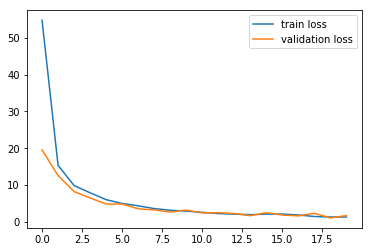

005p_-_01
16319 3875 203
Epoch 1/20
510/510 [==============================] - 752s 1s/step - loss: 50.8655 - val_loss: 17.4580
Epoch 2/20
510/510 [==============================] - 678s 1s/step - loss: 13.8819 - val_loss: 9.6133
Epoch 3/20
510/510 [==============================] - 661s 1s/step - loss: 9.0892 - val_loss: 9.8056
Epoch 4/20
510/510 [==============================] - 704s 1s/step - loss: 7.2526 - val_loss: 5.4249
Epoch 5/20
510/510 [==============================] - 657s 1s/step - loss: 5.7621 - val_loss: 4.1426
Epoch 6/20
510/510 [==============================] - 642s 1s/step - loss: 4.6909 - val_loss: 3.6878
Epoch 7/20
510/510 [==============================] - 658s 1s/step - loss: 3.9451 - val_loss: 3.4300
Epoch 8/20
510/510 [==============================] - 663s 1s/step - loss: 3.4740 - val_loss: 3.6045
Epoch 9/20
510/510 [==============================] - 655s 1s/step - loss: 3.2104 - val_loss: 2.5391
Epoch 10/20
510/510 [==============================] - 677s 1s/

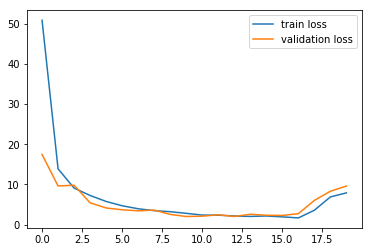

005p_-_02
16319 3875 203
Epoch 1/20
510/510 [==============================] - 522s 1s/step - loss: 55.0630 - val_loss: 26.0807
Epoch 2/20
510/510 [==============================] - 505s 990ms/step - loss: 21.6539 - val_loss: 17.4731
Epoch 3/20
510/510 [==============================] - 503s 986ms/step - loss: 17.4334 - val_loss: 15.5166
Epoch 4/20
510/510 [==============================] - 503s 987ms/step - loss: 14.9601 - val_loss: 13.1180
Epoch 5/20
510/510 [==============================] - 502s 984ms/step - loss: 13.4454 - val_loss: 11.7888
Epoch 6/20
510/510 [==============================] - 503s 985ms/step - loss: 12.8904 - val_loss: 10.8953
Epoch 7/20
510/510 [==============================] - 502s 985ms/step - loss: 11.6560 - val_loss: 10.2871
Epoch 8/20
510/510 [==============================] - 502s 985ms/step - loss: 11.6341 - val_loss: 10.8092
Epoch 9/20
510/510 [==============================] - 503s 987ms/step - loss: 10.7037 - val_loss: 10.5023
Epoch 10/20
510/510 [===

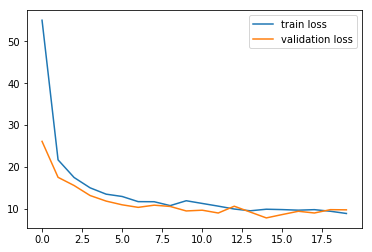

005p_-_03
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 50.4583 - val_loss: 26.7228
Epoch 2/20
510/510 [==============================] - 504s 988ms/step - loss: 21.7096 - val_loss: 15.9720
Epoch 3/20
510/510 [==============================] - 504s 987ms/step - loss: 17.2753 - val_loss: 14.5370
Epoch 4/20
510/510 [==============================] - 503s 986ms/step - loss: 15.2919 - val_loss: 12.9465
Epoch 5/20
510/510 [==============================] - 503s 986ms/step - loss: 14.2266 - val_loss: 12.4231
Epoch 6/20
510/510 [==============================] - 503s 985ms/step - loss: 13.4369 - val_loss: 12.3937
Epoch 7/20
510/510 [==============================] - 503s 986ms/step - loss: 12.2986 - val_loss: 11.0893
Epoch 8/20
510/510 [==============================] - 502s 984ms/step - loss: 12.1857 - val_loss: 11.7112
Epoch 9/20
510/510 [==============================] - 503s 986ms/step - loss: 11.8435 - val_loss: 9.2899
Epoch 10/20
510/510 [====

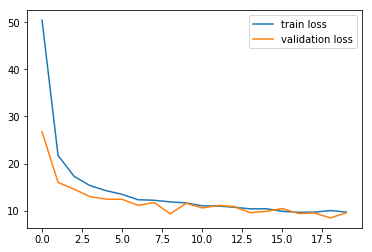

005p_-_04
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 59.7012 - val_loss: 32.4206
Epoch 2/20
510/510 [==============================] - 503s 986ms/step - loss: 24.4245 - val_loss: 17.5845
Epoch 3/20
510/510 [==============================] - 503s 987ms/step - loss: 17.4322 - val_loss: 16.7903
Epoch 4/20
510/510 [==============================] - 504s 988ms/step - loss: 15.3847 - val_loss: 14.1869
Epoch 5/20
510/510 [==============================] - 502s 984ms/step - loss: 13.9675 - val_loss: 11.1642
Epoch 6/20
510/510 [==============================] - 502s 985ms/step - loss: 13.0680 - val_loss: 11.6468
Epoch 7/20
510/510 [==============================] - 502s 984ms/step - loss: 12.6217 - val_loss: 11.3141
Epoch 8/20
510/510 [==============================] - 502s 984ms/step - loss: 12.1332 - val_loss: 12.7670
Epoch 9/20
510/510 [==============================] - 502s 984ms/step - loss: 11.2422 - val_loss: 9.6704
Epoch 10/20
510/510 [====

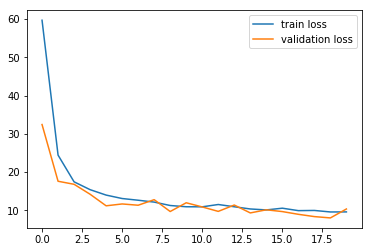

005p_-_05
16319 3875 203
Epoch 1/20
510/510 [==============================] - 513s 1s/step - loss: 66.2286 - val_loss: 31.7001
Epoch 2/20
510/510 [==============================] - 504s 988ms/step - loss: 23.4744 - val_loss: 19.8992
Epoch 3/20
510/510 [==============================] - 503s 987ms/step - loss: 17.6385 - val_loss: 16.5383
Epoch 4/20
510/510 [==============================] - 504s 989ms/step - loss: 15.7326 - val_loss: 13.9493
Epoch 5/20
510/510 [==============================] - 504s 988ms/step - loss: 14.3574 - val_loss: 13.5110
Epoch 6/20
510/510 [==============================] - 504s 989ms/step - loss: 13.5587 - val_loss: 11.3253
Epoch 7/20
510/510 [==============================] - 503s 987ms/step - loss: 12.5403 - val_loss: 11.1156
Epoch 8/20
510/510 [==============================] - 503s 987ms/step - loss: 11.6759 - val_loss: 10.5769
Epoch 9/20
510/510 [==============================] - 502s 985ms/step - loss: 11.4609 - val_loss: 9.7130
Epoch 10/20
510/510 [====

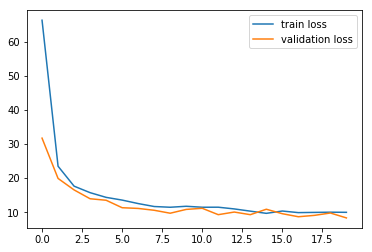

005p_-_06
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 62.9558 - val_loss: 30.3619
Epoch 2/20
510/510 [==============================] - 502s 984ms/step - loss: 23.8581 - val_loss: 18.8989
Epoch 3/20
510/510 [==============================] - 502s 984ms/step - loss: 18.2232 - val_loss: 15.9979
Epoch 4/20
510/510 [==============================] - 502s 985ms/step - loss: 15.4099 - val_loss: 13.9009
Epoch 5/20
510/510 [==============================] - 502s 984ms/step - loss: 14.0911 - val_loss: 12.1938
Epoch 6/20
510/510 [==============================] - 501s 983ms/step - loss: 12.4140 - val_loss: 12.6830
Epoch 7/20
510/510 [==============================] - 502s 984ms/step - loss: 12.9340 - val_loss: 12.2623
Epoch 8/20
510/510 [==============================] - 501s 983ms/step - loss: 11.5727 - val_loss: 11.8140
Epoch 9/20
510/510 [==============================] - 502s 984ms/step - loss: 11.8318 - val_loss: 10.3685
Epoch 10/20
510/510 [===

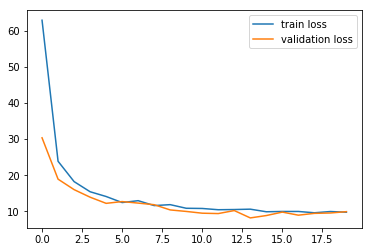

005p_-_07
16319 3875 203
Epoch 1/20
510/510 [==============================] - 511s 1s/step - loss: 58.7678 - val_loss: 27.2434
Epoch 2/20
510/510 [==============================] - 502s 985ms/step - loss: 22.4299 - val_loss: 17.6623
Epoch 3/20
510/510 [==============================] - 503s 986ms/step - loss: 17.3701 - val_loss: 16.5928
Epoch 4/20
510/510 [==============================] - 501s 983ms/step - loss: 15.3990 - val_loss: 15.2917
Epoch 5/20
510/510 [==============================] - 502s 985ms/step - loss: 13.6852 - val_loss: 12.6679
Epoch 6/20
510/510 [==============================] - 503s 986ms/step - loss: 13.1465 - val_loss: 12.1762
Epoch 7/20
510/510 [==============================] - 502s 985ms/step - loss: 12.1304 - val_loss: 12.2262
Epoch 8/20
510/510 [==============================] - 502s 984ms/step - loss: 11.8863 - val_loss: 10.9671
Epoch 9/20
510/510 [==============================] - 504s 988ms/step - loss: 11.5158 - val_loss: 9.3104
Epoch 10/20
510/510 [====

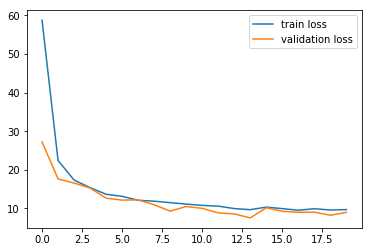

005p_-_08
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 56.2382 - val_loss: 24.9674
Epoch 2/20
510/510 [==============================] - 502s 985ms/step - loss: 22.5761 - val_loss: 18.1444
Epoch 3/20
510/510 [==============================] - 503s 986ms/step - loss: 18.1012 - val_loss: 15.2306
Epoch 4/20
510/510 [==============================] - 503s 987ms/step - loss: 15.7202 - val_loss: 13.6798
Epoch 5/20
510/510 [==============================] - 503s 986ms/step - loss: 13.5335 - val_loss: 12.2499
Epoch 6/20
510/510 [==============================] - 504s 989ms/step - loss: 13.8811 - val_loss: 13.8550
Epoch 7/20
510/510 [==============================] - 503s 987ms/step - loss: 13.0752 - val_loss: 11.4414
Epoch 8/20
510/510 [==============================] - 503s 986ms/step - loss: 12.0546 - val_loss: 11.6178
Epoch 9/20
510/510 [==============================] - 503s 986ms/step - loss: 11.2306 - val_loss: 11.0559
Epoch 10/20
510/510 [===

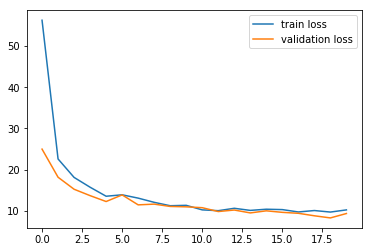

005p_-_09
16319 3875 203
Epoch 1/20
510/510 [==============================] - 511s 1s/step - loss: 49.3792 - val_loss: 23.9178
Epoch 2/20
510/510 [==============================] - 504s 988ms/step - loss: 21.7475 - val_loss: 17.5319
Epoch 3/20
510/510 [==============================] - 504s 987ms/step - loss: 16.9982 - val_loss: 17.0627
Epoch 4/20
510/510 [==============================] - 503s 987ms/step - loss: 14.9145 - val_loss: 13.7265
Epoch 5/20
510/510 [==============================] - 503s 986ms/step - loss: 13.2480 - val_loss: 12.9976
Epoch 6/20
510/510 [==============================] - 502s 985ms/step - loss: 12.4348 - val_loss: 11.4693
Epoch 7/20
510/510 [==============================] - 503s 986ms/step - loss: 11.4491 - val_loss: 9.8519
Epoch 8/20
510/510 [==============================] - 503s 986ms/step - loss: 11.3228 - val_loss: 10.3640
Epoch 9/20
510/510 [==============================] - 503s 987ms/step - loss: 11.2294 - val_loss: 10.3619
Epoch 10/20
510/510 [====

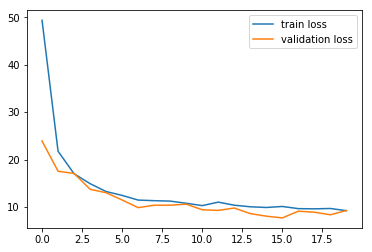

010p_-_00
16319 3875 203
Epoch 1/20
510/510 [==============================] - 983s 2s/step - loss: 49.0090 - val_loss: 20.0360
Epoch 2/20
510/510 [==============================] - 682s 1s/step - loss: 14.4607 - val_loss: 10.2900
Epoch 3/20
510/510 [==============================] - 588s 1s/step - loss: 11.8133 - val_loss: 8.9807
Epoch 4/20
510/510 [==============================] - 537s 1s/step - loss: 12.4852 - val_loss: 10.6719
Epoch 5/20
510/510 [==============================] - 515s 1s/step - loss: 12.8103 - val_loss: 11.4697
Epoch 6/20
510/510 [==============================] - 507s 994ms/step - loss: 12.2951 - val_loss: 10.6632
Epoch 7/20
510/510 [==============================] - 503s 986ms/step - loss: 12.6869 - val_loss: 11.3210
Epoch 8/20
510/510 [==============================] - 502s 985ms/step - loss: 11.2457 - val_loss: 11.2677
Epoch 9/20
510/510 [==============================] - 502s 985ms/step - loss: 11.0421 - val_loss: 9.7225
Epoch 10/20
510/510 [=================

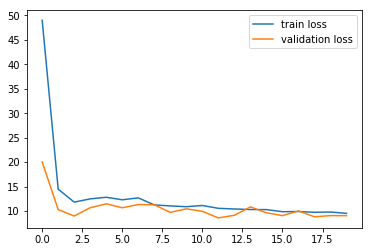

010p_-_01
16319 3875 203
Epoch 1/20
510/510 [==============================] - 513s 1s/step - loss: 59.6487 - val_loss: 28.1388
Epoch 2/20
510/510 [==============================] - 502s 985ms/step - loss: 22.8087 - val_loss: 18.6056
Epoch 3/20
510/510 [==============================] - 501s 982ms/step - loss: 17.0932 - val_loss: 13.8018
Epoch 4/20
510/510 [==============================] - 501s 982ms/step - loss: 15.2262 - val_loss: 15.7062
Epoch 5/20
510/510 [==============================] - 502s 985ms/step - loss: 14.0148 - val_loss: 12.4622
Epoch 6/20
510/510 [==============================] - 501s 982ms/step - loss: 12.8359 - val_loss: 12.2923
Epoch 7/20
510/510 [==============================] - 502s 983ms/step - loss: 11.9690 - val_loss: 10.9858
Epoch 8/20
510/510 [==============================] - 501s 983ms/step - loss: 12.0140 - val_loss: 11.2173
Epoch 9/20
510/510 [==============================] - 502s 984ms/step - loss: 11.1199 - val_loss: 11.5966
Epoch 10/20
510/510 [===

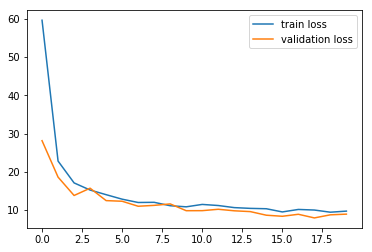

010p_-_02
16319 3875 203
Epoch 1/20
510/510 [==============================] - 509s 999ms/step - loss: 59.2889 - val_loss: 30.1667
Epoch 2/20
510/510 [==============================] - 500s 981ms/step - loss: 22.7870 - val_loss: 17.7544
Epoch 3/20
510/510 [==============================] - 500s 981ms/step - loss: 16.6745 - val_loss: 14.4858
Epoch 4/20
510/510 [==============================] - 501s 983ms/step - loss: 14.8596 - val_loss: 13.2973
Epoch 5/20
510/510 [==============================] - 501s 983ms/step - loss: 13.4150 - val_loss: 12.8787
Epoch 6/20
510/510 [==============================] - 501s 983ms/step - loss: 13.4091 - val_loss: 10.5140
Epoch 7/20
510/510 [==============================] - 501s 982ms/step - loss: 11.9209 - val_loss: 10.4898
Epoch 8/20
510/510 [==============================] - 502s 984ms/step - loss: 11.8648 - val_loss: 9.6093
Epoch 9/20
510/510 [==============================] - 501s 982ms/step - loss: 11.4202 - val_loss: 10.1872
Epoch 10/20
510/510 [=

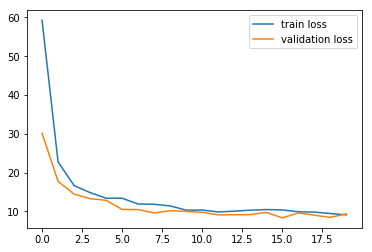

010p_-_03
16319 3875 203
Epoch 1/20
510/510 [==============================] - 510s 1s/step - loss: 59.0830 - val_loss: 27.8615
Epoch 2/20
510/510 [==============================] - 502s 985ms/step - loss: 22.5129 - val_loss: 18.6658
Epoch 3/20
510/510 [==============================] - 503s 986ms/step - loss: 17.6364 - val_loss: 14.4753
Epoch 4/20
510/510 [==============================] - 502s 984ms/step - loss: 14.6409 - val_loss: 12.7635
Epoch 5/20
510/510 [==============================] - 500s 981ms/step - loss: 13.8113 - val_loss: 13.7460
Epoch 6/20
510/510 [==============================] - 501s 981ms/step - loss: 12.9344 - val_loss: 12.2648
Epoch 7/20
510/510 [==============================] - 501s 982ms/step - loss: 12.4162 - val_loss: 10.9216
Epoch 8/20
510/510 [==============================] - 501s 981ms/step - loss: 11.9473 - val_loss: 10.1003
Epoch 9/20
510/510 [==============================] - 502s 984ms/step - loss: 11.3329 - val_loss: 9.6608
Epoch 10/20
510/510 [====

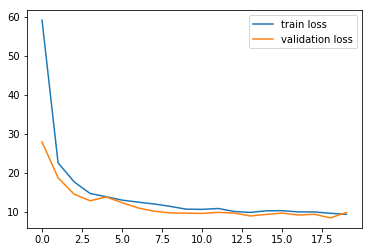

010p_-_04
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 61.1222 - val_loss: 29.8061
Epoch 2/20
510/510 [==============================] - 502s 985ms/step - loss: 22.9951 - val_loss: 17.4101
Epoch 3/20
510/510 [==============================] - 504s 988ms/step - loss: 17.3133 - val_loss: 14.9406
Epoch 4/20
510/510 [==============================] - 503s 987ms/step - loss: 14.7708 - val_loss: 14.1253
Epoch 5/20
510/510 [==============================] - 505s 990ms/step - loss: 13.5909 - val_loss: 11.6796
Epoch 6/20
510/510 [==============================] - 503s 986ms/step - loss: 12.0952 - val_loss: 12.1021
Epoch 7/20
510/510 [==============================] - 504s 989ms/step - loss: 12.2288 - val_loss: 11.0645
Epoch 8/20
510/510 [==============================] - 503s 986ms/step - loss: 11.4462 - val_loss: 10.8371
Epoch 9/20
510/510 [==============================] - 503s 986ms/step - loss: 11.5850 - val_loss: 9.4369
Epoch 10/20
510/510 [====

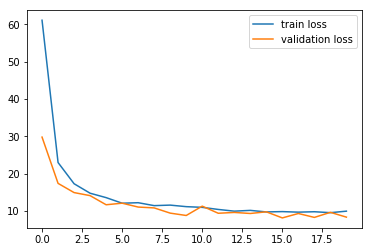

010p_-_05
16319 3875 203
Epoch 1/20
510/510 [==============================] - 510s 1000ms/step - loss: 59.6948 - val_loss: 27.8429
Epoch 2/20
510/510 [==============================] - 501s 983ms/step - loss: 23.6401 - val_loss: 17.6205
Epoch 3/20
510/510 [==============================] - 501s 982ms/step - loss: 18.1007 - val_loss: 15.2188
Epoch 4/20
510/510 [==============================] - 500s 980ms/step - loss: 15.4200 - val_loss: 13.3344
Epoch 5/20
510/510 [==============================] - 501s 982ms/step - loss: 14.7460 - val_loss: 12.4458
Epoch 6/20
510/510 [==============================] - 501s 982ms/step - loss: 13.8897 - val_loss: 13.1148
Epoch 7/20
510/510 [==============================] - 501s 982ms/step - loss: 12.9845 - val_loss: 12.0504
Epoch 8/20
510/510 [==============================] - 501s 982ms/step - loss: 12.5891 - val_loss: 11.5974
Epoch 9/20
510/510 [==============================] - 503s 985ms/step - loss: 12.1850 - val_loss: 9.9883
Epoch 10/20
510/510 [

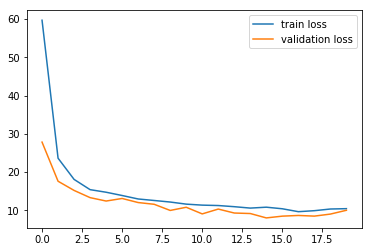

010p_-_06
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 53.6723 - val_loss: 24.6195
Epoch 2/20
510/510 [==============================] - 502s 984ms/step - loss: 21.9572 - val_loss: 18.0873
Epoch 3/20
510/510 [==============================] - 502s 984ms/step - loss: 17.5703 - val_loss: 13.7943
Epoch 4/20
510/510 [==============================] - 501s 982ms/step - loss: 15.0866 - val_loss: 12.7270
Epoch 5/20
510/510 [==============================] - 502s 984ms/step - loss: 14.1235 - val_loss: 11.5418
Epoch 6/20
510/510 [==============================] - 502s 985ms/step - loss: 13.1009 - val_loss: 11.3016
Epoch 7/20
510/510 [==============================] - 501s 982ms/step - loss: 12.5608 - val_loss: 12.5801
Epoch 8/20
510/510 [==============================] - 500s 981ms/step - loss: 11.7378 - val_loss: 10.6718
Epoch 9/20
510/510 [==============================] - 501s 982ms/step - loss: 11.2725 - val_loss: 10.5597
Epoch 10/20
510/510 [===

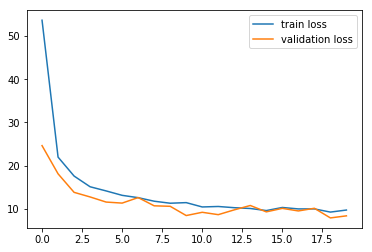

010p_-_07
16319 3875 203
Epoch 1/20
510/510 [==============================] - 510s 1s/step - loss: 56.7873 - val_loss: 25.5294
Epoch 2/20
510/510 [==============================] - 502s 985ms/step - loss: 21.0245 - val_loss: 18.1624
Epoch 3/20
510/510 [==============================] - 501s 982ms/step - loss: 17.0712 - val_loss: 14.7877
Epoch 4/20
510/510 [==============================] - 501s 983ms/step - loss: 15.0033 - val_loss: 13.9903
Epoch 5/20
510/510 [==============================] - 501s 983ms/step - loss: 13.6407 - val_loss: 12.5706
Epoch 6/20
510/510 [==============================] - 501s 981ms/step - loss: 12.7130 - val_loss: 11.9710
Epoch 7/20
510/510 [==============================] - 502s 985ms/step - loss: 11.9775 - val_loss: 12.1143
Epoch 8/20
510/510 [==============================] - 502s 984ms/step - loss: 11.6810 - val_loss: 11.3249
Epoch 9/20
510/510 [==============================] - 501s 983ms/step - loss: 11.1700 - val_loss: 10.5828
Epoch 10/20
510/510 [===

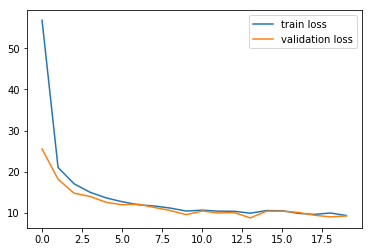

010p_-_08
16319 3875 203
Epoch 1/20
510/510 [==============================] - 511s 1s/step - loss: 61.8922 - val_loss: 35.5301
Epoch 2/20
510/510 [==============================] - 501s 983ms/step - loss: 24.4849 - val_loss: 19.7335
Epoch 3/20
510/510 [==============================] - 501s 982ms/step - loss: 17.9211 - val_loss: 16.7078
Epoch 4/20
510/510 [==============================] - 501s 983ms/step - loss: 14.9957 - val_loss: 13.6693
Epoch 5/20
510/510 [==============================] - 501s 983ms/step - loss: 13.7554 - val_loss: 11.5634
Epoch 6/20
510/510 [==============================] - 502s 984ms/step - loss: 13.5455 - val_loss: 11.4154
Epoch 7/20
510/510 [==============================] - 502s 984ms/step - loss: 12.4679 - val_loss: 10.9969
Epoch 8/20
510/510 [==============================] - 502s 985ms/step - loss: 11.5024 - val_loss: 9.4715
Epoch 9/20
510/510 [==============================] - 502s 985ms/step - loss: 11.3048 - val_loss: 9.2281
Epoch 10/20
510/510 [=====

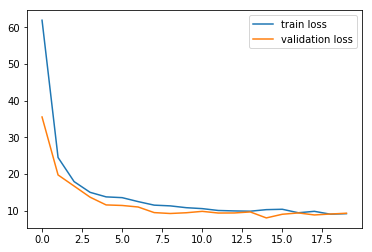

010p_-_09
16319 3875 203
Epoch 1/20
510/510 [==============================] - 512s 1s/step - loss: 59.5811 - val_loss: 29.4032
Epoch 2/20
510/510 [==============================] - 503s 987ms/step - loss: 22.4032 - val_loss: 16.7065
Epoch 3/20
510/510 [==============================] - 503s 986ms/step - loss: 17.2858 - val_loss: 14.2196
Epoch 4/20
510/510 [==============================] - 503s 986ms/step - loss: 15.1254 - val_loss: 12.9977
Epoch 5/20
510/510 [==============================] - 503s 986ms/step - loss: 14.3073 - val_loss: 12.7580
Epoch 6/20
510/510 [==============================] - 504s 988ms/step - loss: 12.5719 - val_loss: 12.1376
Epoch 7/20
510/510 [==============================] - 503s 987ms/step - loss: 12.6876 - val_loss: 11.0705
Epoch 8/20
510/510 [==============================] - 503s 986ms/step - loss: 12.5436 - val_loss: 10.4529
Epoch 9/20
510/510 [==============================] - 504s 988ms/step - loss: 11.9534 - val_loss: 10.1219
Epoch 10/20
510/510 [===

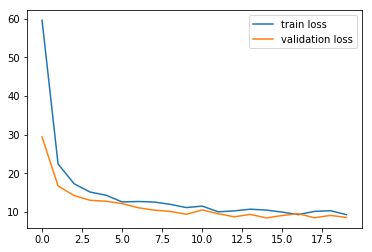

015p_-_00
16319 3875 203
Epoch 1/20
510/510 [==============================] - 960s 2s/step - loss: 54.5431 - val_loss: 20.3548
Epoch 2/20
510/510 [==============================] - 687s 1s/step - loss: 15.1393 - val_loss: 10.1641
Epoch 3/20
510/510 [==============================] - 586s 1s/step - loss: 12.4590 - val_loss: 10.8346
Epoch 4/20
510/510 [==============================] - 542s 1s/step - loss: 13.0955 - val_loss: 10.9877
Epoch 5/20
510/510 [==============================] - 515s 1s/step - loss: 12.8885 - val_loss: 9.9099
Epoch 6/20
510/510 [==============================] - 507s 995ms/step - loss: 13.2845 - val_loss: 11.4446
Epoch 7/20
510/510 [==============================] - 504s 988ms/step - loss: 12.7540 - val_loss: 11.2373
Epoch 8/20
510/510 [==============================] - 503s 986ms/step - loss: 11.5325 - val_loss: 10.2197
Epoch 9/20
510/510 [==============================] - 503s 985ms/step - loss: 11.8705 - val_loss: 10.0128
Epoch 10/20
510/510 [================

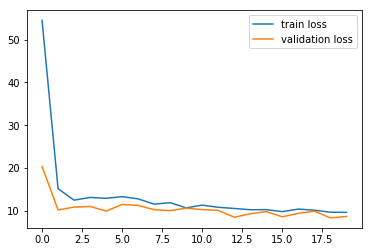

015p_-_01
16319 3875 203
Epoch 1/20
510/510 [==============================] - 516s 1s/step - loss: 56.6274 - val_loss: 27.2002
Epoch 2/20
510/510 [==============================] - 504s 988ms/step - loss: 21.9814 - val_loss: 17.6350
Epoch 3/20
510/510 [==============================] - 504s 987ms/step - loss: 17.1228 - val_loss: 14.9485
Epoch 4/20
510/510 [==============================] - 503s 987ms/step - loss: 15.3212 - val_loss: 13.8383
Epoch 5/20
510/510 [==============================] - 502s 984ms/step - loss: 13.4229 - val_loss: 12.9380
Epoch 6/20
510/510 [==============================] - 501s 983ms/step - loss: 13.5333 - val_loss: 12.6081
Epoch 7/20
510/510 [==============================] - 500s 981ms/step - loss: 11.9574 - val_loss: 11.0203
Epoch 8/20
510/510 [==============================] - 501s 982ms/step - loss: 12.0375 - val_loss: 11.2435
Epoch 9/20
510/510 [==============================] - 502s 985ms/step - loss: 11.7728 - val_loss: 11.0975
Epoch 10/20
510/510 [===

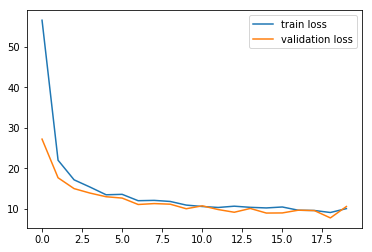

015p_-_02
16319 3875 203
Epoch 1/20
510/510 [==============================] - 511s 1s/step - loss: 54.9041 - val_loss: 23.0745
Epoch 2/20
510/510 [==============================] - 502s 984ms/step - loss: 21.4385 - val_loss: 15.9983
Epoch 3/20
510/510 [==============================] - 501s 982ms/step - loss: 16.7972 - val_loss: 13.9516
Epoch 4/20
510/510 [==============================] - 501s 982ms/step - loss: 15.1196 - val_loss: 13.3570
Epoch 5/20
510/510 [==============================] - 502s 984ms/step - loss: 13.8714 - val_loss: 11.9565
Epoch 6/20
510/510 [==============================] - 501s 983ms/step - loss: 13.3038 - val_loss: 11.8698
Epoch 7/20
510/510 [==============================] - 500s 981ms/step - loss: 12.3037 - val_loss: 10.3088
Epoch 8/20
510/510 [==============================] - 501s 982ms/step - loss: 11.1029 - val_loss: 9.6054
Epoch 9/20
510/510 [==============================] - 500s 981ms/step - loss: 10.8942 - val_loss: 10.4017
Epoch 10/20
510/510 [====

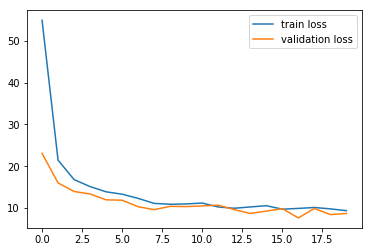

015p_-_03
16319 3875 203
Epoch 1/20
510/510 [==============================] - 511s 1s/step - loss: 62.7241 - val_loss: 32.7434
Epoch 2/20
510/510 [==============================] - 501s 983ms/step - loss: 25.1342 - val_loss: 18.6784
Epoch 3/20
510/510 [==============================] - 502s 984ms/step - loss: 18.9514 - val_loss: 15.8324
Epoch 4/20
510/510 [==============================] - 501s 983ms/step - loss: 15.7279 - val_loss: 14.7989
Epoch 5/20
510/510 [==============================] - 501s 983ms/step - loss: 14.1931 - val_loss: 14.0014
Epoch 6/20
510/510 [==============================] - 501s 983ms/step - loss: 13.5406 - val_loss: 12.2324
Epoch 7/20
510/510 [==============================] - 502s 984ms/step - loss: 12.2875 - val_loss: 12.3031
Epoch 8/20
510/510 [==============================] - 501s 982ms/step - loss: 12.2728 - val_loss: 10.9007
Epoch 9/20
510/510 [==============================] - 502s 985ms/step - loss: 11.8626 - val_loss: 11.3864
Epoch 10/20
510/510 [===

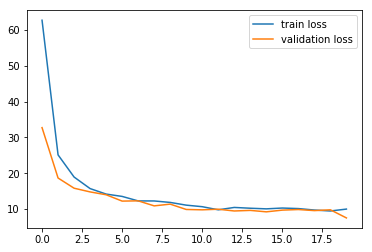

015p_-_04
16319 3875 203
Epoch 1/20
510/510 [==============================] - 509s 998ms/step - loss: 59.5058 - val_loss: 31.0615
Epoch 2/20
510/510 [==============================] - 500s 981ms/step - loss: 22.9493 - val_loss: 17.3617
Epoch 3/20
510/510 [==============================] - 501s 983ms/step - loss: 17.9454 - val_loss: 15.2210
Epoch 4/20
510/510 [==============================] - 500s 980ms/step - loss: 15.1395 - val_loss: 14.3455
Epoch 5/20
510/510 [==============================] - 506s 992ms/step - loss: 13.7079 - val_loss: 14.8127
Epoch 6/20
510/510 [==============================] - 510s 1s/step - loss: 12.9640 - val_loss: 11.7379
Epoch 7/20
510/510 [==============================] - 511s 1s/step - loss: 12.9044 - val_loss: 10.1856
Epoch 8/20
510/510 [==============================] - 509s 999ms/step - loss: 11.8098 - val_loss: 11.9228
Epoch 9/20
510/510 [==============================] - 507s 993ms/step - loss: 11.8584 - val_loss: 10.5846
Epoch 10/20
510/510 [======

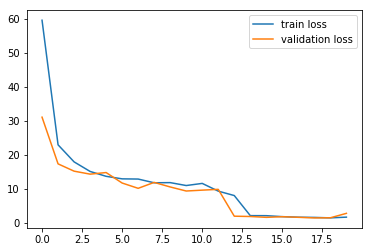

015p_-_05
16319 3875 203
Epoch 1/20
510/510 [==============================] - 634s 1s/step - loss: 56.9863 - val_loss: 24.2252
Epoch 2/20
510/510 [==============================] - 605s 1s/step - loss: 16.9985 - val_loss: 11.6235
Epoch 3/20
510/510 [==============================] - 690s 1s/step - loss: 10.8571 - val_loss: 10.0766
Epoch 4/20
510/510 [==============================] - 595s 1s/step - loss: 9.3303 - val_loss: 10.4862
Epoch 5/20
510/510 [==============================] - 565s 1s/step - loss: 10.3423 - val_loss: 11.2512
Epoch 6/20
510/510 [==============================] - 527s 1s/step - loss: 11.3790 - val_loss: 11.0854
Epoch 7/20
510/510 [==============================] - 509s 999ms/step - loss: 11.8508 - val_loss: 10.5415
Epoch 8/20
510/510 [==============================] - 504s 988ms/step - loss: 11.7910 - val_loss: 10.4093
Epoch 9/20
510/510 [==============================] - 503s 986ms/step - loss: 11.5240 - val_loss: 10.9957
Epoch 10/20
510/510 [===================

In [ ]:
train_files = []
train_data = []
valid_data = []
test_data = []

output_dir = 'training_output'
os.makedirs(output_dir, exist_ok=True)

for thresh in [0.05, 0.10, 0.15, 0.20, 1.11]:
    for sample_i in range(5):
        suffix = "%03dp"%(np.round(100.0*thresh))
        train_files[:] = sorted(glob.glob('./train_%s/*.npz'%suffix))
        total_n_train = len(train_files)
        fsuffix = "%s_-_%02d"%(suffix, sample_i)
        print(fsuffix)
        # test_files = sorted(glob.glob('./test/*.npz'))
        model_fname = os.path.join(output_dir, 'speed_test_model_%s.h5'%fsuffix)
        if os.path.isfile(model_fname):
            continue
            
        n_train, n_valid, n_test = int(0.8*total_n_train), int(0.19*total_n_train), int(0.01*total_n_train)

        print(n_train, n_valid, n_test)
        train_steps = int(np.ceil(float(n_train) / float(BATCH_SIZE)))
        valid_steps = int(np.ceil(float(n_valid) / float(BATCH_SIZE)))
        test_steps = int(np.ceil(float(n_test) / float(BATCH_SIZE)))

        train_ids = np.random.choice(total_n_train, size=n_train, replace=False)
        avail_ids = np.setdiff1d(np.arange(total_n_train), train_ids)
        test_ids = np.random.choice(avail_ids, size=n_test, replace=False)
        valid_ids = np.setdiff1d(avail_ids, test_ids)

        train_data[:] = [train_files[i] for i in train_ids]
        valid_data[:] = [train_files[i] for i in valid_ids]
        test_data[:] = [train_files[i] for i in test_ids]

        train_gen = train_generator(train_data, BATCH_SIZE)
        valid_gen = train_generator(valid_data, BATCH_SIZE)
        test_gen = train_generator(test_data, BATCH_SIZE)

        model = cnn_model()

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

        model_fname = os.path.join(output_dir, 'best_val_model_%s.h5'%fsuffix)
        mc = ModelCheckpoint(model_fname, monitor='val_loss', 
                             mode='min', save_best_only=True)

        model_fname = os.path.join(output_dir, 'best_train_model_%s.h5'%fsuffix)
        mc = ModelCheckpoint(model_fname, monitor='loss', 
                             mode='min', save_best_only=True)

        #     optimizer = rmsprop(lr=0.0001, decay=1e-6)
        optimizer = Adam(
            lr=0.00001, 
        #         beta_1=0.9, 
        #         beta_2=0.999, 
        #         epsilon=None, 
        #         decay=0.0, 
            amsgrad=bool(1)
        )

        model.compile(optimizer=optimizer, loss='mse')

        # test_gen = test_generator(test_files, BATCH_SIZE)

        fit_log = model.fit_generator(
            train_gen, 
            steps_per_epoch=train_steps, 
            validation_data=valid_gen,
            validation_steps=valid_steps,
            epochs=20,
            verbose=1,
            shuffle=True,
        )

        history_fname = os.path.join(output_dir, 'train_history_dict_%s.pickle'%fsuffix)
        with open(history_fname, 'wb') as file_pi:
                pickle.dump(fit_log.history, file_pi)


        model_fname = os.path.join(output_dir, 'speed_test_model_%s.h5'%fsuffix)
        model.save(model_fname)

        fig = plt.figure()
        ax = plt.subplot(1, 1, 1)
        plt.plot(fit_log.history['loss'], label='train loss')
        plt.plot(fit_log.history['val_loss'], label='validation loss')
        plt.legend()
        plt.show()

        #scores = model.evaluate()

In [ ]:
thresh = 0.05
suffix = "%03dp"%(np.round(100.0*thresh))
train_files[:] = sorted(glob.glob('./train_%s/*.npz'%suffix))
total_n_train = len(train_files)
sample_i = 0
n_epochs = 200
fsuffix = "%s_-_%02d_%04d"%(suffix, sample_i, n_epochs)
print(fsuffix)
# test_files = sorted(glob.glob('./test/*.npz'))

n_train, n_valid, n_test = int(0.8*total_n_train), int(0.19*total_n_train), int(0.01*total_n_train)

print(n_train, n_valid, n_test)
train_steps = int(np.ceil(float(n_train) / float(BATCH_SIZE)))
valid_steps = int(np.ceil(float(n_valid) / float(BATCH_SIZE)))
test_steps = int(np.ceil(float(n_test) / float(BATCH_SIZE)))

train_ids = np.random.choice(total_n_train, size=n_train, replace=False)
avail_ids = np.setdiff1d(np.arange(total_n_train), train_ids)
test_ids = np.random.choice(avail_ids, size=n_test, replace=False)
valid_ids = np.setdiff1d(avail_ids, test_ids)

train_data[:] = [train_files[i] for i in train_ids]
valid_data[:] = [train_files[i] for i in valid_ids]
test_data[:] = [train_files[i] for i in test_ids]

train_gen = train_generator(train_data, BATCH_SIZE)
valid_gen = train_generator(valid_data, BATCH_SIZE)
test_gen = train_generator(test_data, BATCH_SIZE)


output_dir = 'training_output'
os.makedirs(output_dir, exist_ok=True)

model = cnn_model()


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

model_fname = os.path.join(output_dir, 'best_val_model_%s.h5'%fsuffix)
mc = ModelCheckpoint(model_fname, monitor='val_loss', 
                     mode='min', save_best_only=True)

model_fname = os.path.join(output_dir, 'best_train_model_%s.h5'%fsuffix)
mc = ModelCheckpoint(model_fname, monitor='loss', 
                     mode='min', save_best_only=True)



#     optimizer = rmsprop(lr=0.0001, decay=1e-6)
optimizer = Adam(
    lr=0.00001, 
#         beta_1=0.9, 
#         beta_2=0.999, 
#         epsilon=None, 
#         decay=0.0, 
    amsgrad=bool(1)
)

model.compile(optimizer=optimizer, loss='mse')

# test_gen = test_generator(test_files, BATCH_SIZE)

fit_log = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_steps, 
    validation_data=valid_gen,
    validation_steps=valid_steps,
    epochs=n_epochs,
    verbose=1,
    shuffle=True,
)

history_fname = os.path.join(output_dir, 'train_history_dict_%s.pickle'%fsuffix)
with open(history_fname, 'wb') as file_pi:
        pickle.dump(fit_log.history, file_pi)


model_fname = os.path.join(output_dir, 'speed_test_model_%s.h5'%fsuffix)
model.save(model_fname)

fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(fit_log.history['loss'], label='train loss')
plt.plot(fit_log.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


In [93]:
scores = model.evaluate_generator(test_gen, steps=test_steps, verbose=1)
print(scores)

7/7 [==============================] - 12s 2s/step
0.6187808683940342


In [43]:
scores

0.4782133272715977

In [ ]:
plot_model(model)

In [ ]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(fit_log.history['loss'])
plt.show()

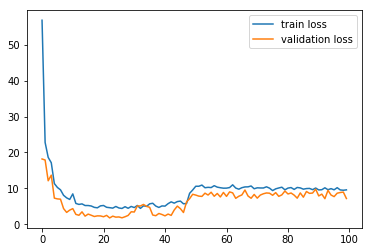

In [ ]:
print(dir(model))

In [ ]:
# print(model.summary())
print(model.weights)
# plt.figure()
# plt.plot(model.summary())